In [1]:
from dinosaur.xarray_utils import data_to_xarray
from dinosaur import primitive_equations as pe
from dinosaur import primitive_equations_states as pes
from dinosaur import spherical_harmonic as sh
from dinosaur.scales import units

from jcm.model import SpeedyModel

import numpy as np
import jax

jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", True) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan


In [2]:
model = SpeedyModel(time_step=30, save_interval=3, total_time=36, layers=8) # takes 40 seconds on laptop gpu
state = model.get_initial_state()
final_state, predictions = model.unroll(state)

In [3]:
# extract dynamics predictions (State format)
# and physics predictions (PhysicsData format) from postprocessed output
dynamics_predictions = predictions['dynamics']
physics_predictions = predictions['physics']

In [4]:
# prepare dynamics predictions for xarray conversion:
# convert from modal to nodal, and dimensionalize
 
u_nodal, v_nodal = sh.vor_div_to_uv_nodal(model.coords.horizontal,
                                          dynamics_predictions.vorticity,
                                          dynamics_predictions.divergence)

# This doesn't currently work for predictions because of the explicit padding shape in there
# w_nodal = -pe.compute_vertical_velocity(predictions, coords)

diagnostic_state_preds = pe.compute_diagnostic_state(dynamics_predictions, model.coords)

# Do the unit conversion before converting to xarray
t_ref = 288 #K
diagnostic_state_preds.temperature_variation = t_ref + model.physics_specs.dimensionalize(diagnostic_state_preds.temperature_variation, units.kelvin).m

diagnostic_state_preds.tracers['specific_humidity'] = model.physics_specs.dimensionalize(diagnostic_state_preds.tracers['specific_humidity'], units.gram / units.kilogram).m

In [5]:
# prepare physics predictions for xarray conversion:
# unpack into single dictionary, and unpack/transpose individual fields

# unpack PhysicsData struct
physics_state_preds = {
    f"{module}.{field}": value # avoids name conflicts between fields of different modules
    for module, module_dict in physics_predictions.asdict().items()
    for field, value in module_dict.asdict().items()
}

# replace multi-channel fields with a field for each channel
_original_keys = list(physics_state_preds.keys())
for k in _original_keys:
    v = physics_state_preds[k]
    if len(v.shape) == 5 or (len(v.shape) == 4 and v.shape[-1] != model.coords.nodal_shape[0]):
        physics_state_preds.update(
            {f"{k}.{i}": v[..., i] for i in range(v.shape[-1])}
        )
        del physics_state_preds[k]

# convert x, y, z to z, x, y to match dinosaur dimension ordering
for k, v in physics_state_preds.items():
    if v.shape[1:4] == model.coords.nodal_shape[1:] + (model.coords.nodal_shape[0],):
        physics_state_preds[k] = np.moveaxis(v, (0, 1, 2, 3), (0, 2, 3, 1))

In [6]:
# create xarray dataset
 
nodal_predictions = {
    **diagnostic_state_preds.asdict(),
    **physics_state_preds
}

broken_keys = ['cos_lat_u', 'cos_lat_grad_log_sp', 'cos_lat_grad_log_sp', ] # These are tuples which are not supported by xarray
broken_keys += ['sigma_dot_explicit', 'sigma_dot_full'] # These only have four time steps for some reason...
pred_ds = data_to_xarray({k: v for k, v in nodal_predictions.items() if k not in broken_keys}, 
                         coords=model.coords, times=model.times)
pred_ds = pred_ds.rename_vars({'temperature_variation': 'temperature'})

# Skip this for now
# log_surface_pressure_nodal = coords.horizontal.to_nodal(final_state.log_surface_pressure)
# surface_pressure_nodal = np.exp(log_surface_pressure_nodal) * 1e5

pred_ds['u'] = data_to_xarray({'u': model.physics_specs.dimensionalize(np.asarray(u_nodal), units.meter / units.second).m}, coords=model.coords, times=model.times)['u']
pred_ds['v'] = data_to_xarray({'v': model.physics_specs.dimensionalize(np.asarray(v_nodal), units.meter / units.second).m}, coords=model.coords, times=model.times)['v']

# Flip the vertical dimension so that it goes from the surface to the top of the atmosphere
pred_ds = pred_ds.isel(level=slice(None, None, -1))

# convert integer time (in days) to datetime
pred_ds['time'] = (model.start_date.delta.days + pred_ds.time).astype('datetime64[D]')

pred_ds

/tmp/ipykernel_120983/114557876.py:25: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  pred_ds['time'] = (model.start_date.delta.days + pred_ds.time).astype('datetime64[D]')


<xarray.Dataset> Size: 86MB
Dimensions:                 (time: 12, level: 8, lon: 128, lat: 64)
Coordinates:
  * lon                     (lon) float64 1kB 0.0 2.812 5.625 ... 354.4 357.2
  * lat                     (lat) float64 512B -87.86 -85.1 ... 85.1 87.86
  * level                   (level) float64 64B 0.9375 0.8125 ... 0.1875 0.0625
  * time                    (time) datetime64[ns] 96B 2000-01-04 ... 2000-02-06
Data variables: (12/80)
    vorticity               (time, level, lon, lat) float32 3MB 0.0 ... 0.1012
    surface_flux.v0         (time, lon, lat) float32 393kB 0.0 0.0 ... -1.91
    convection.iptop        (time, lon, lat) int32 393kB 1 1 1 1 1 ... 1 2 2 2 2
    surface_flux.fmask      (time, lon, lat) float32 393kB 0.0 0.0 ... 0.0 0.0
    humidity.rh             (time, level, lon, lat) float32 3MB 9.614e-09 ......
    humidity.qsat           (time, level, lon, lat) float32 3MB 10.63 ... 0.3552
    ...                      ...
    mod_radcon.flux.1       (time, lon, lat) float32 393kB 27.75 27.67 ... 0.0
    mod_radcon.st4a.0       (time, level, lon, lat) float32 3MB 390.1 ... 120.8
    mod_radcon.flux.3       (time, lon, lat) float32 393kB 0.0 0.0 ... 0.0 0.0
    specific_humidity       (time, level, lon, lat) float32 3MB 1.022e-07 ......
    u                       (time, level, lon, lat) float32 3MB 0.0 ... -11.46
    v                       (time, level, lon, lat) float32 3MB 0.0 ... -7.997
Attributes:
    longitude_wavenumbers:     43
    total_wavenumbers:         44
    longitude_nodes:           128
    latitude_nodes:            64
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonics
    spmd_mesh:                 
    boundaries:                [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0....
    horizontal_grid_type:      Grid
    vertical_grid_type:        SigmaCoordinates

In [7]:
print(f"dataset size: {pred_ds.nbytes/1e6:.1f}MB")

dataset size: 85.7MB


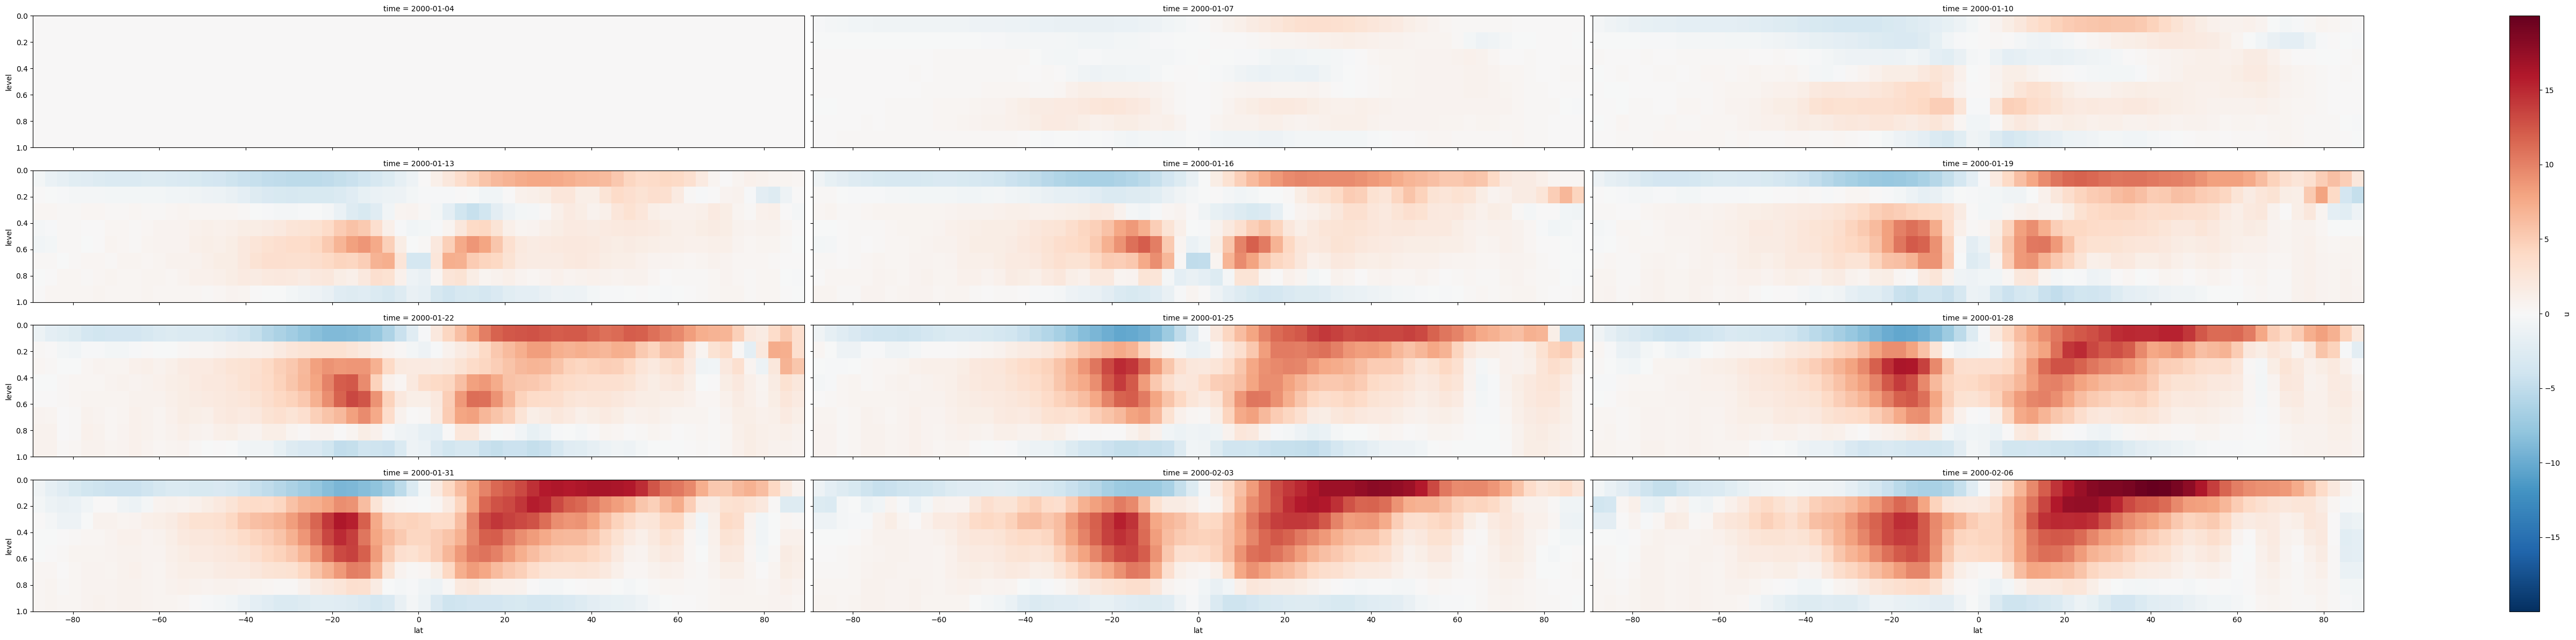

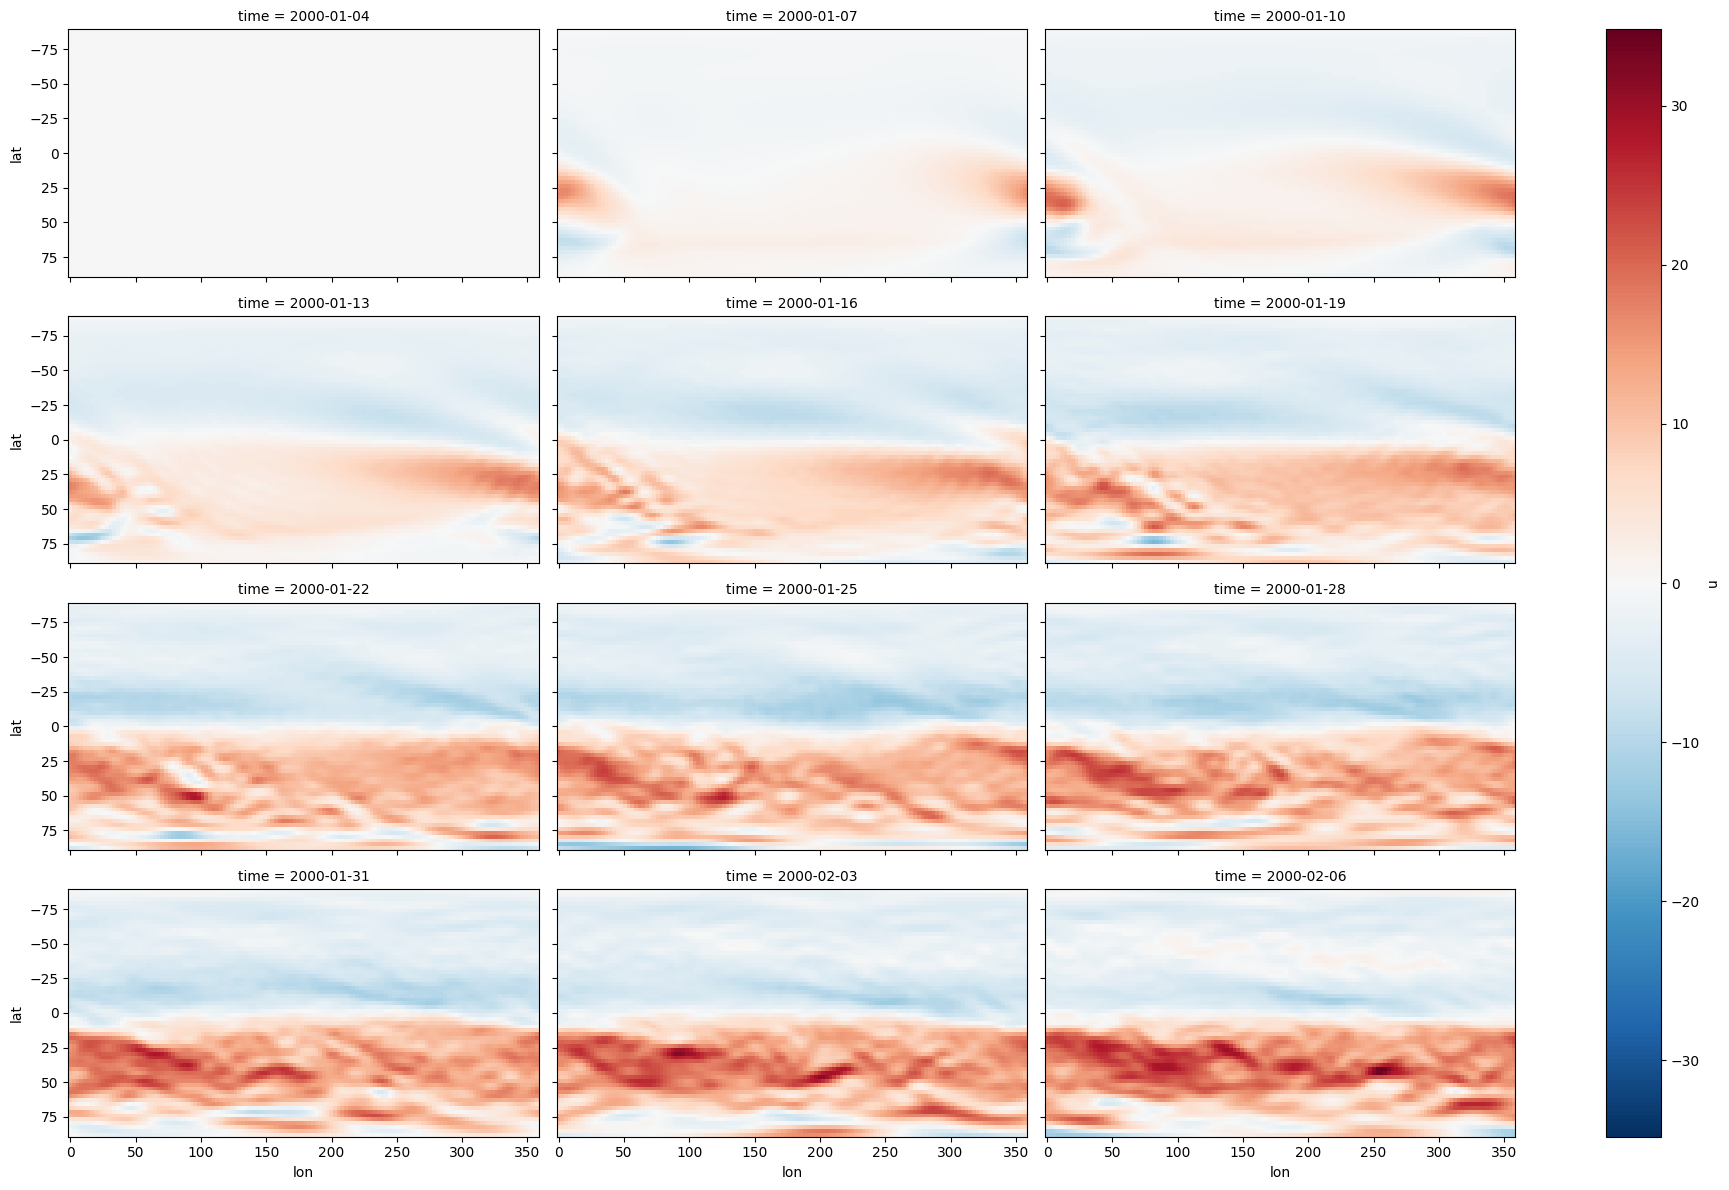

In [16]:
pred_ds['u'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False);
pred_ds['u'].isel(level=-1).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2, yincrease=False);

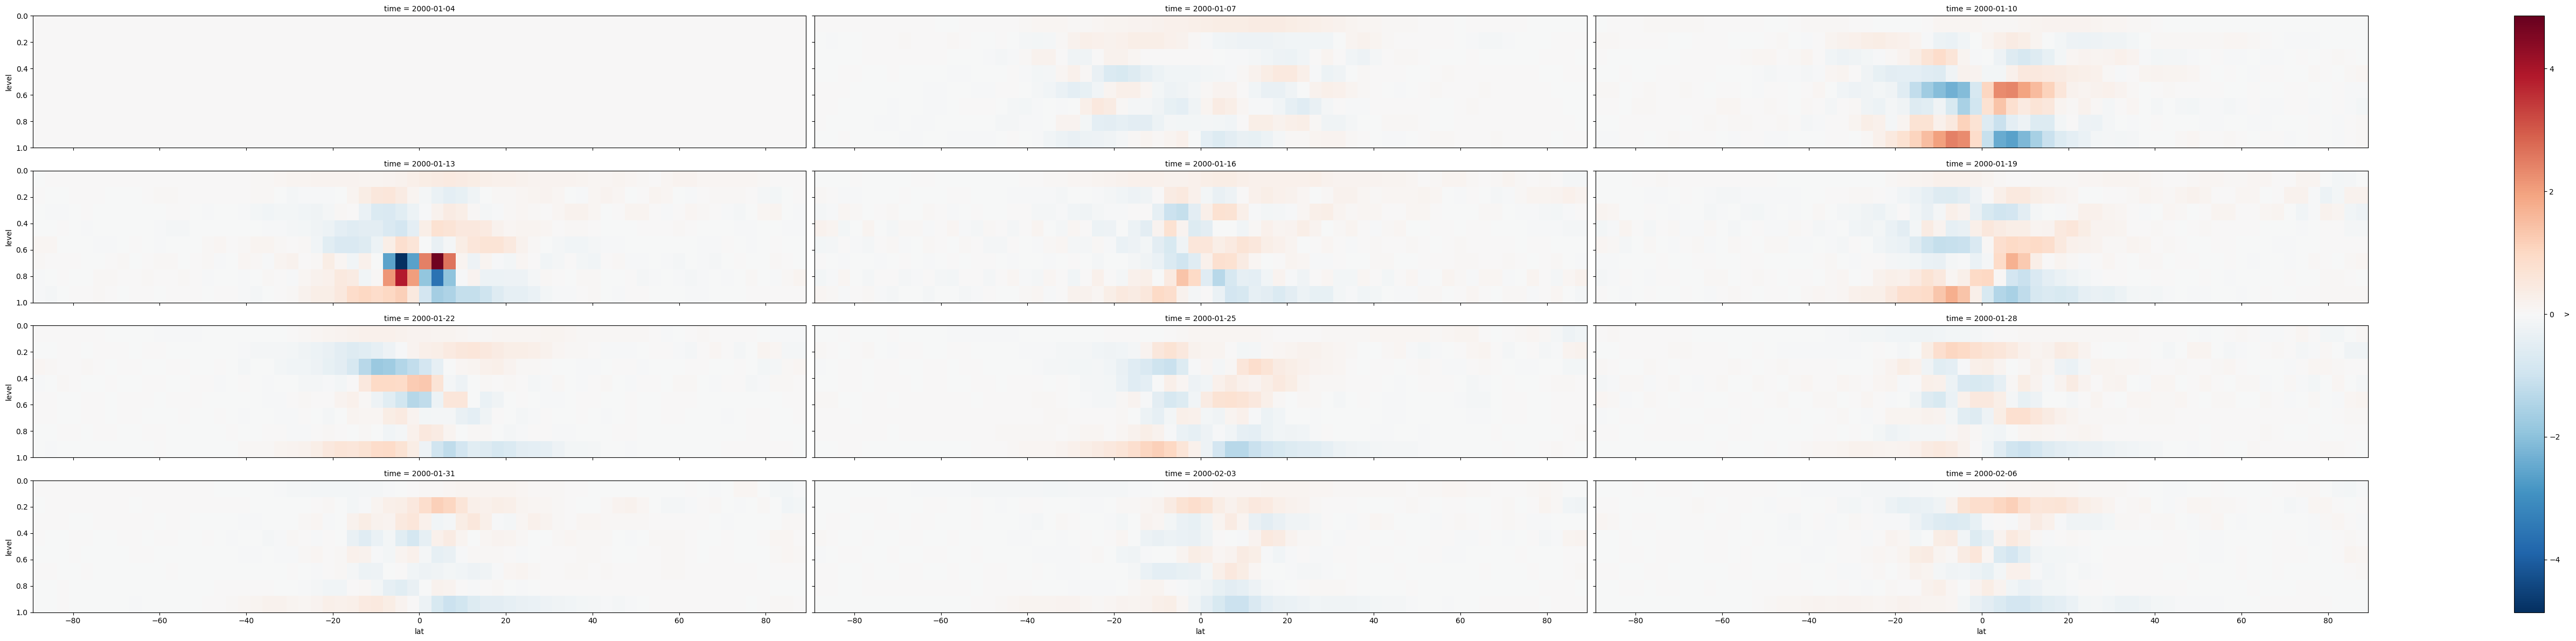

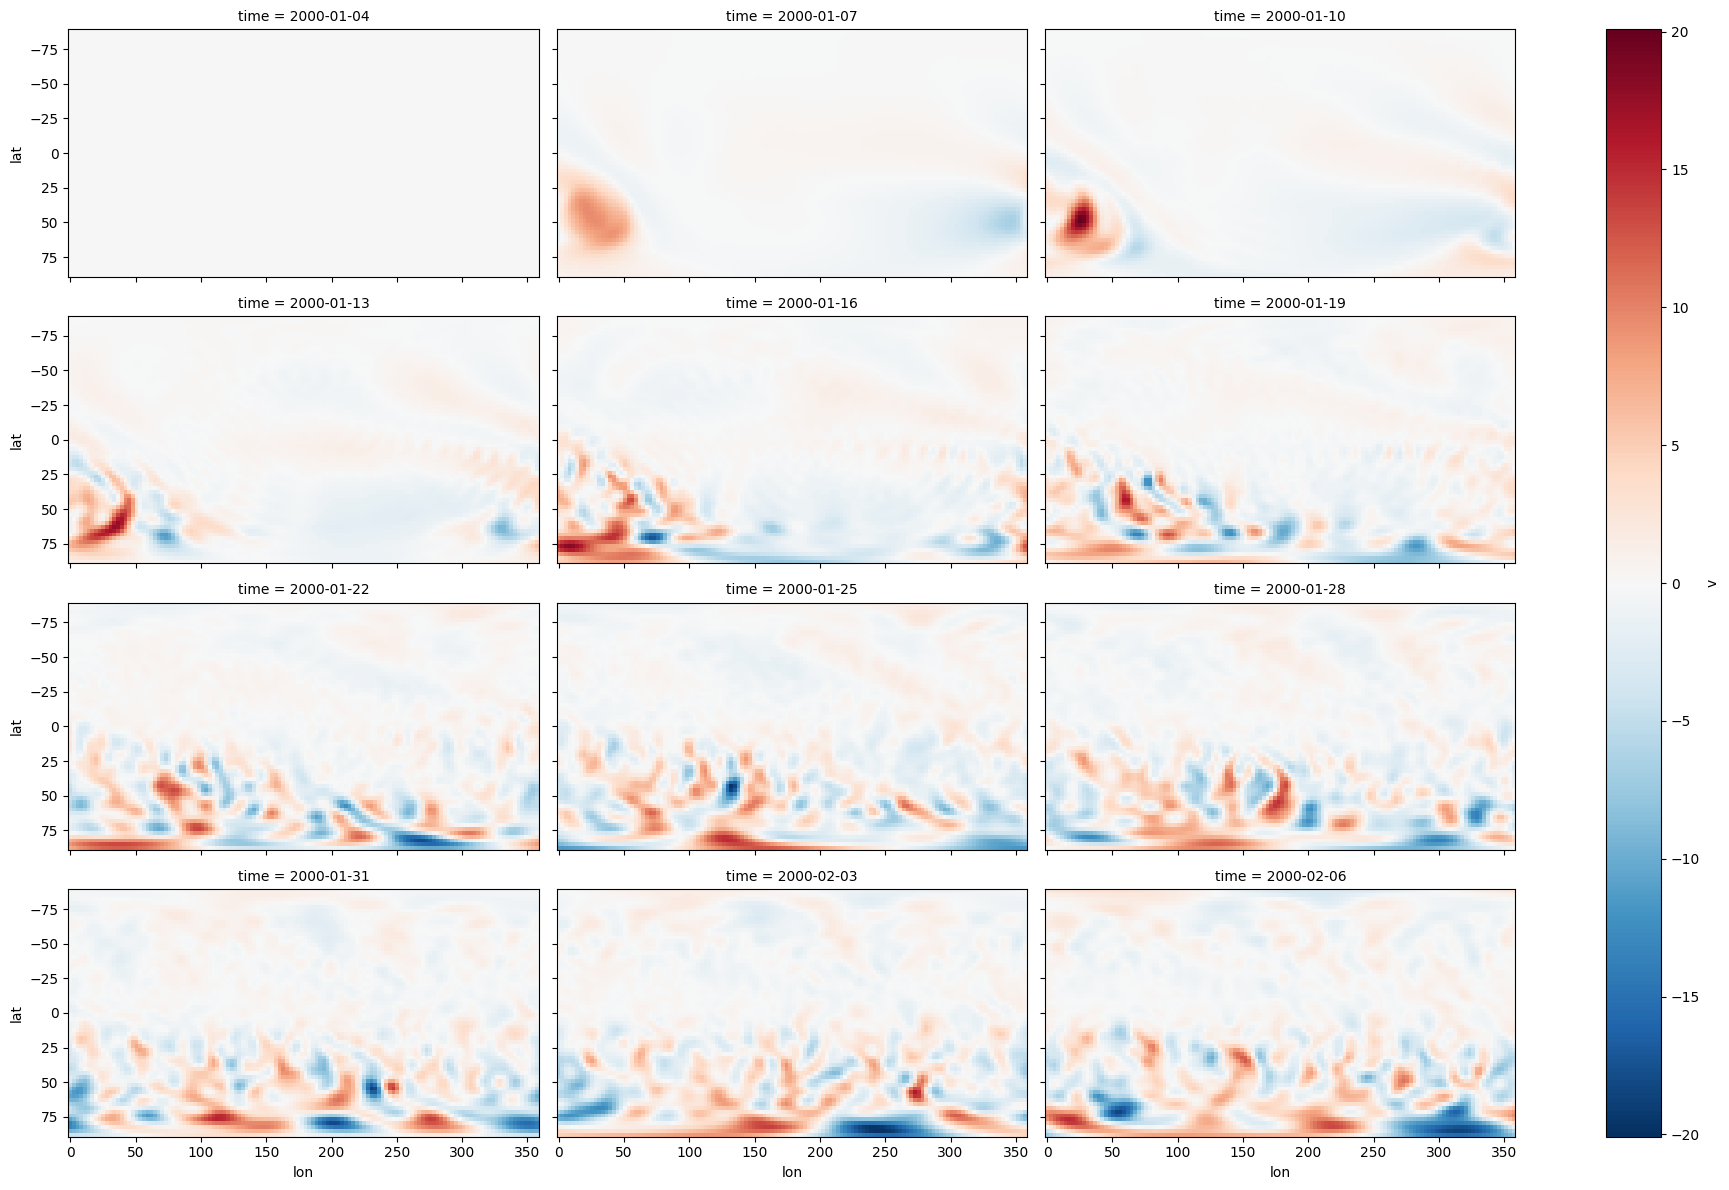

In [17]:
pred_ds['v'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False);
pred_ds['v'].isel(level=-1).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2, yincrease=False);

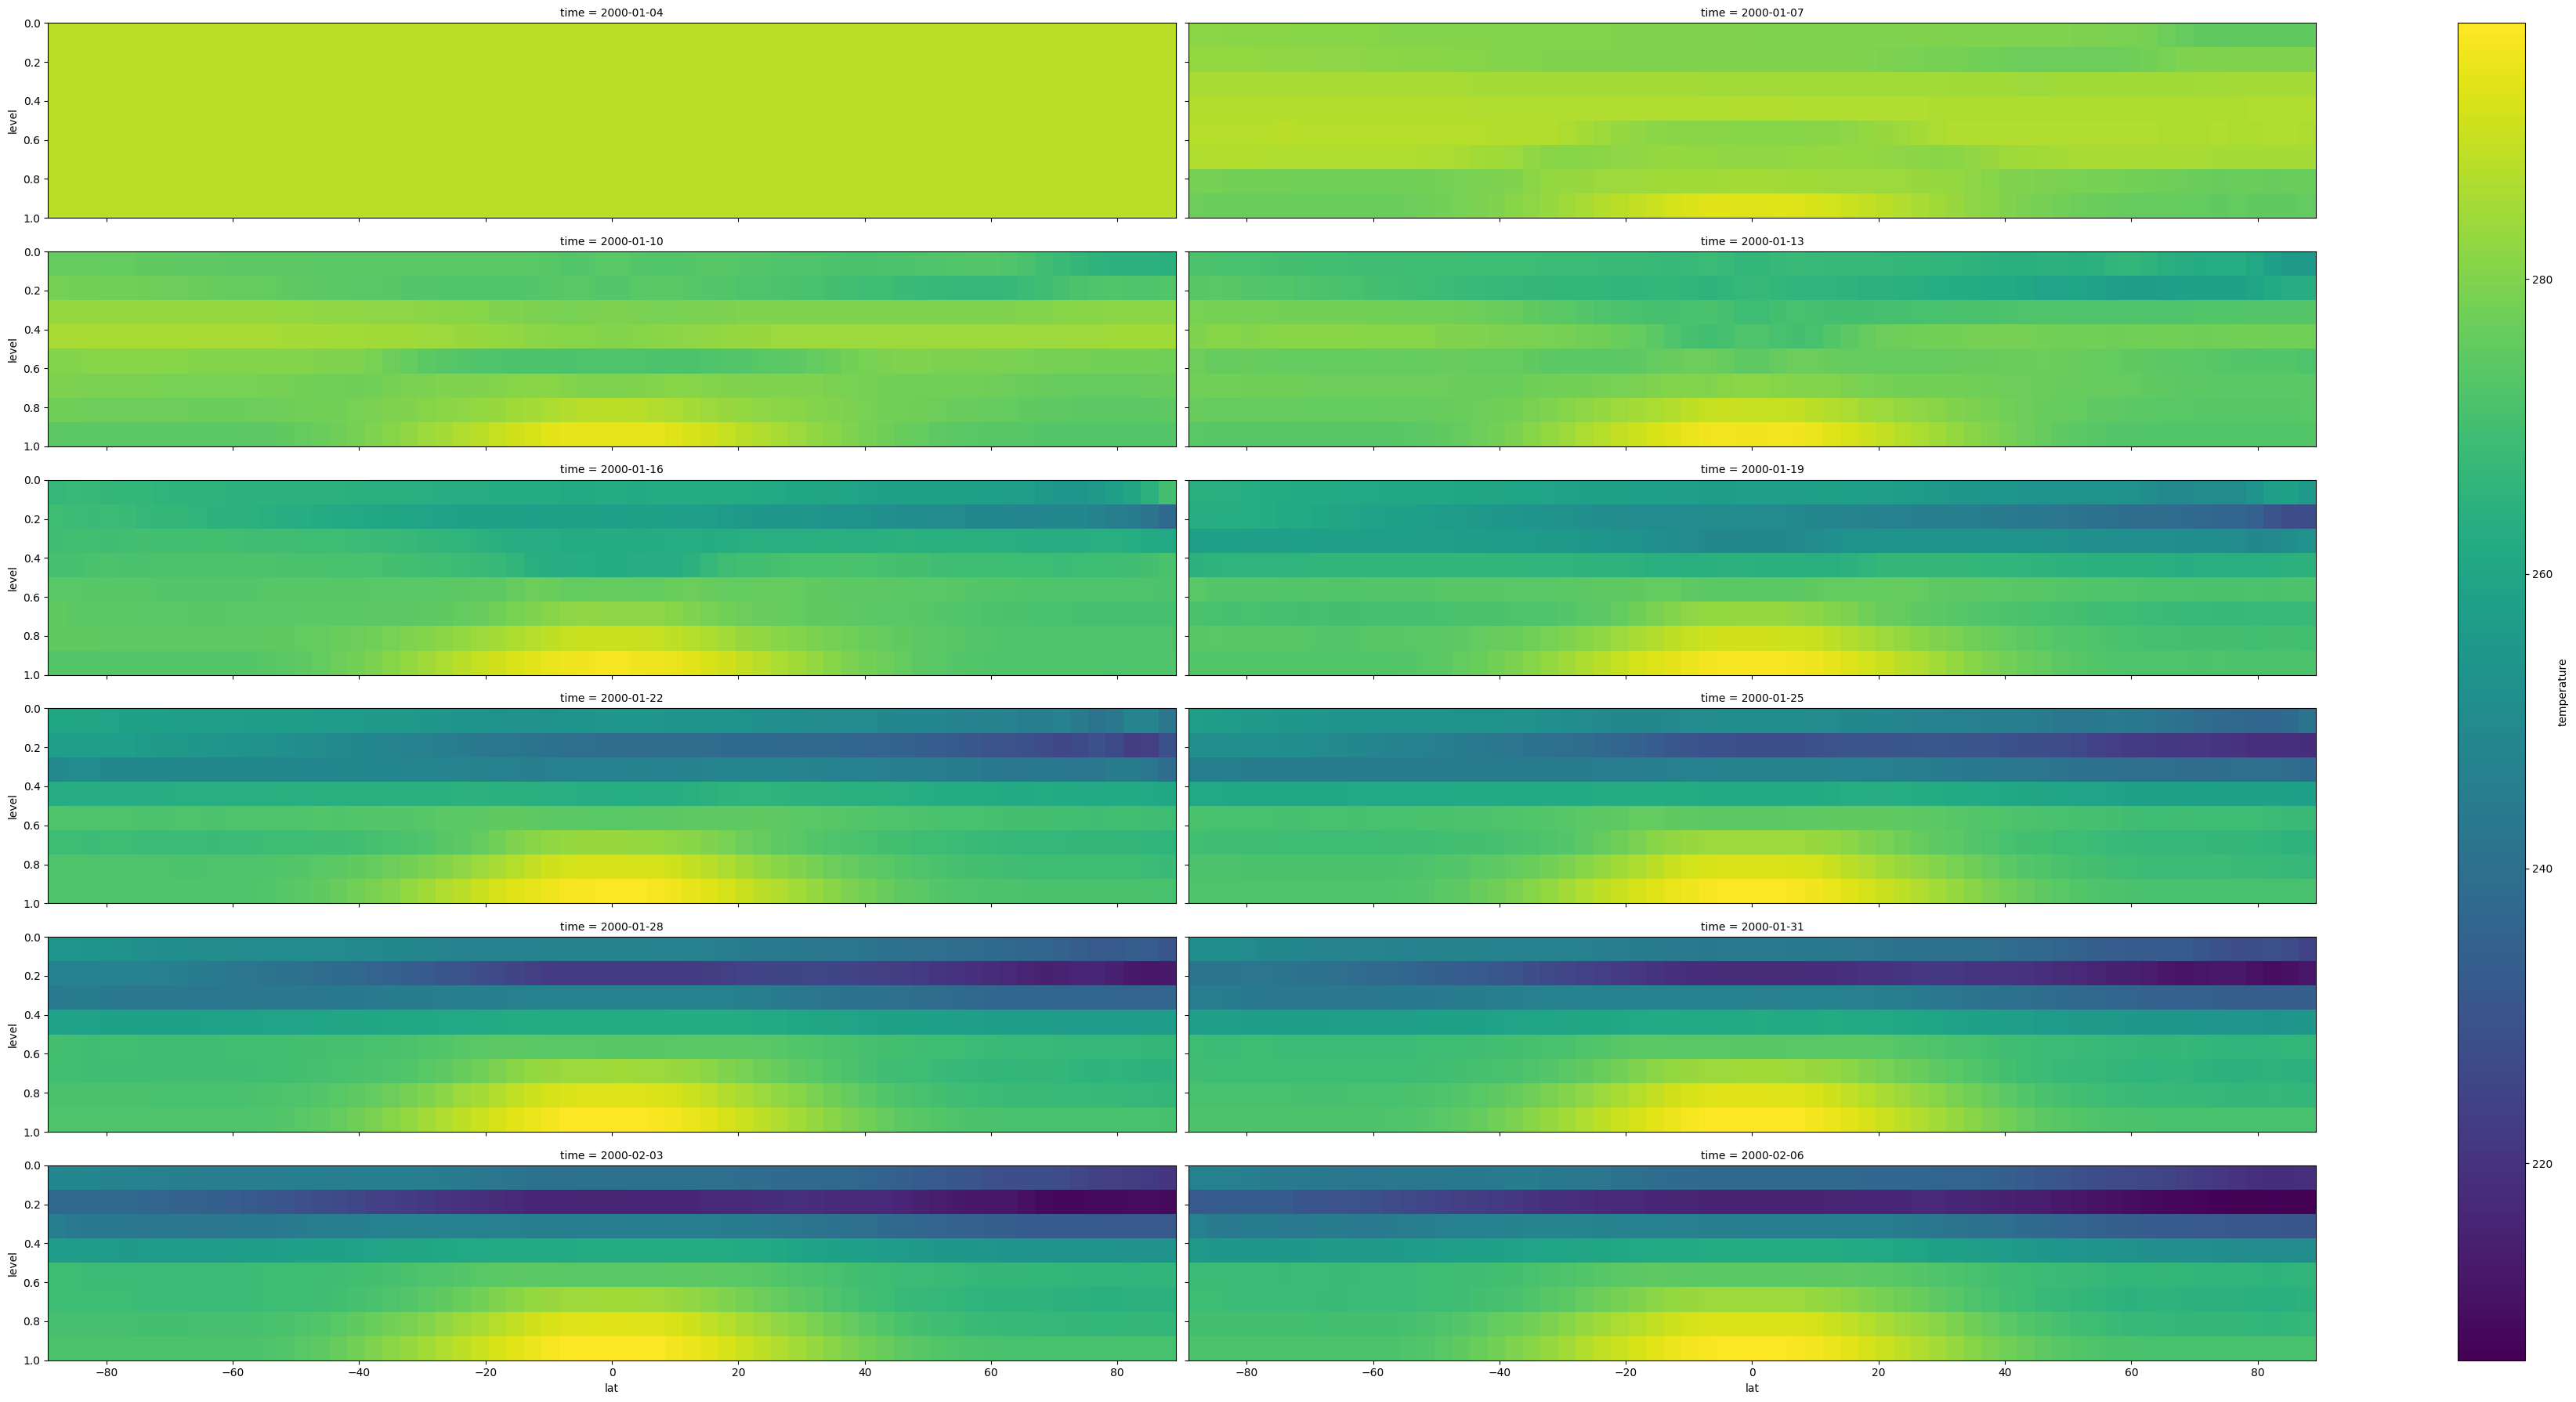

In [19]:
pred_ds['temperature'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=2, aspect=6, yincrease=False);

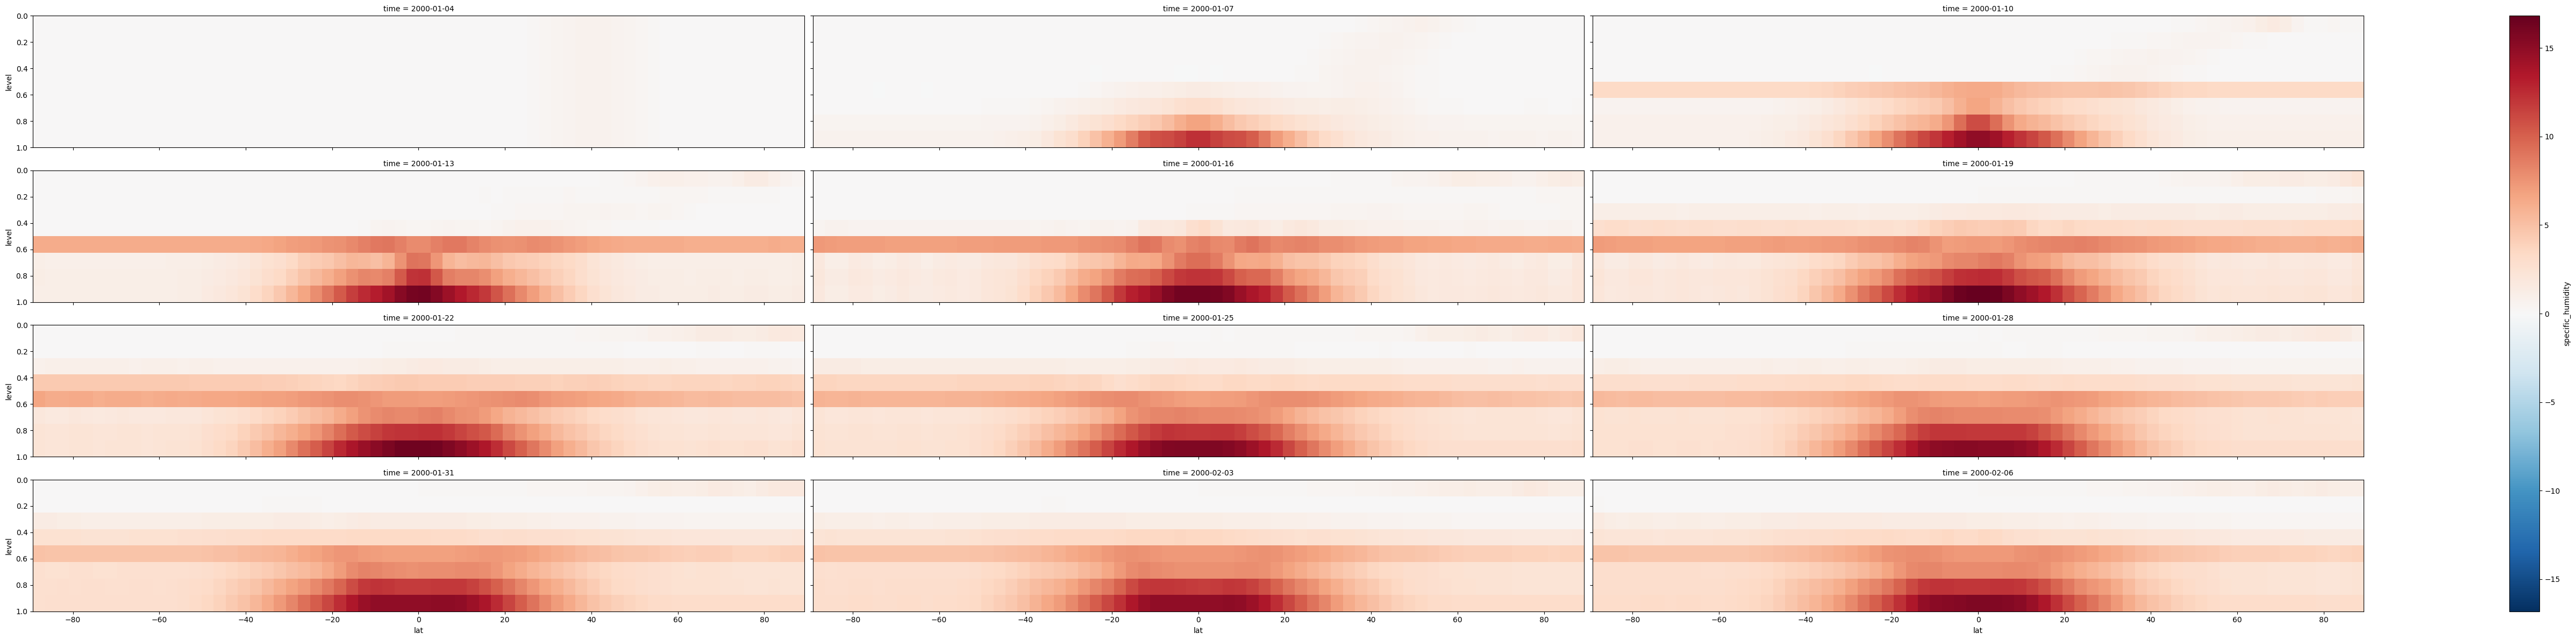

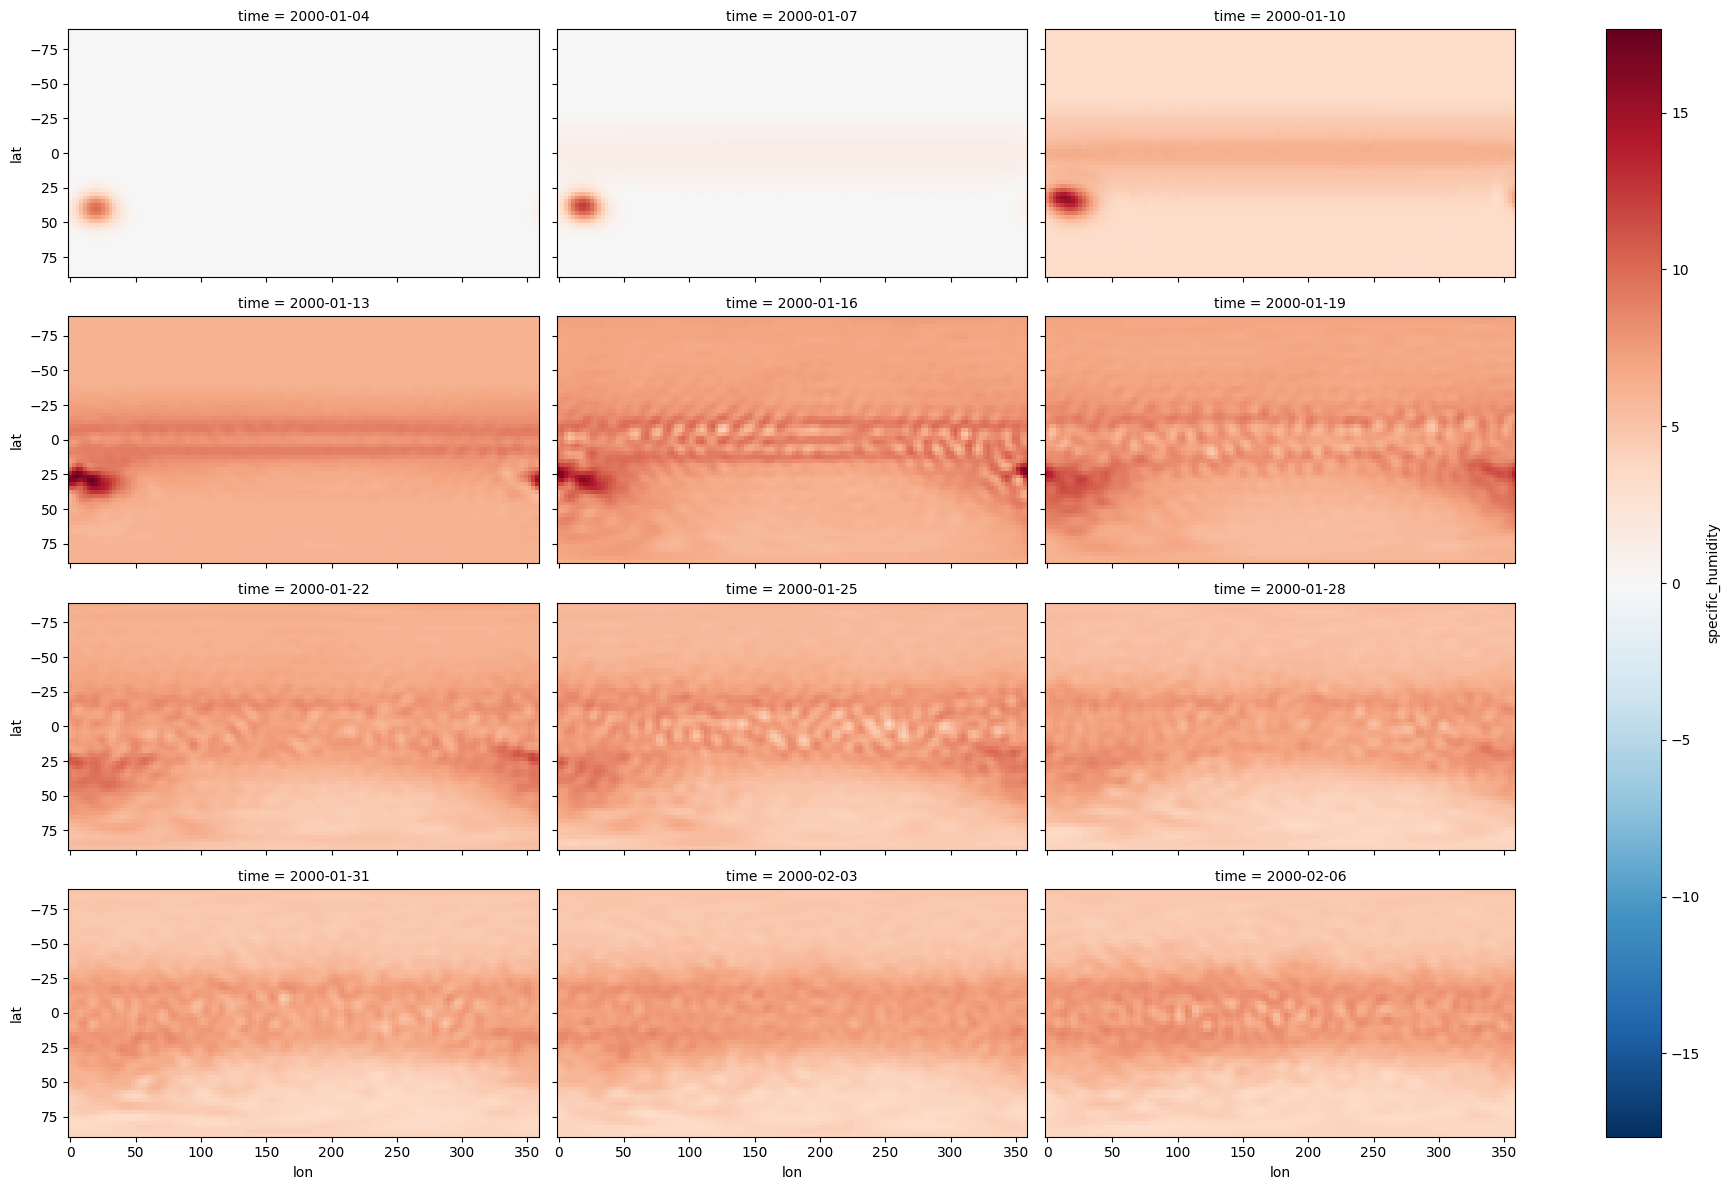

In [20]:
pred_ds['specific_humidity'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False);
pred_ds['specific_humidity'].isel(level=3).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2, yincrease=False);

### clouds!

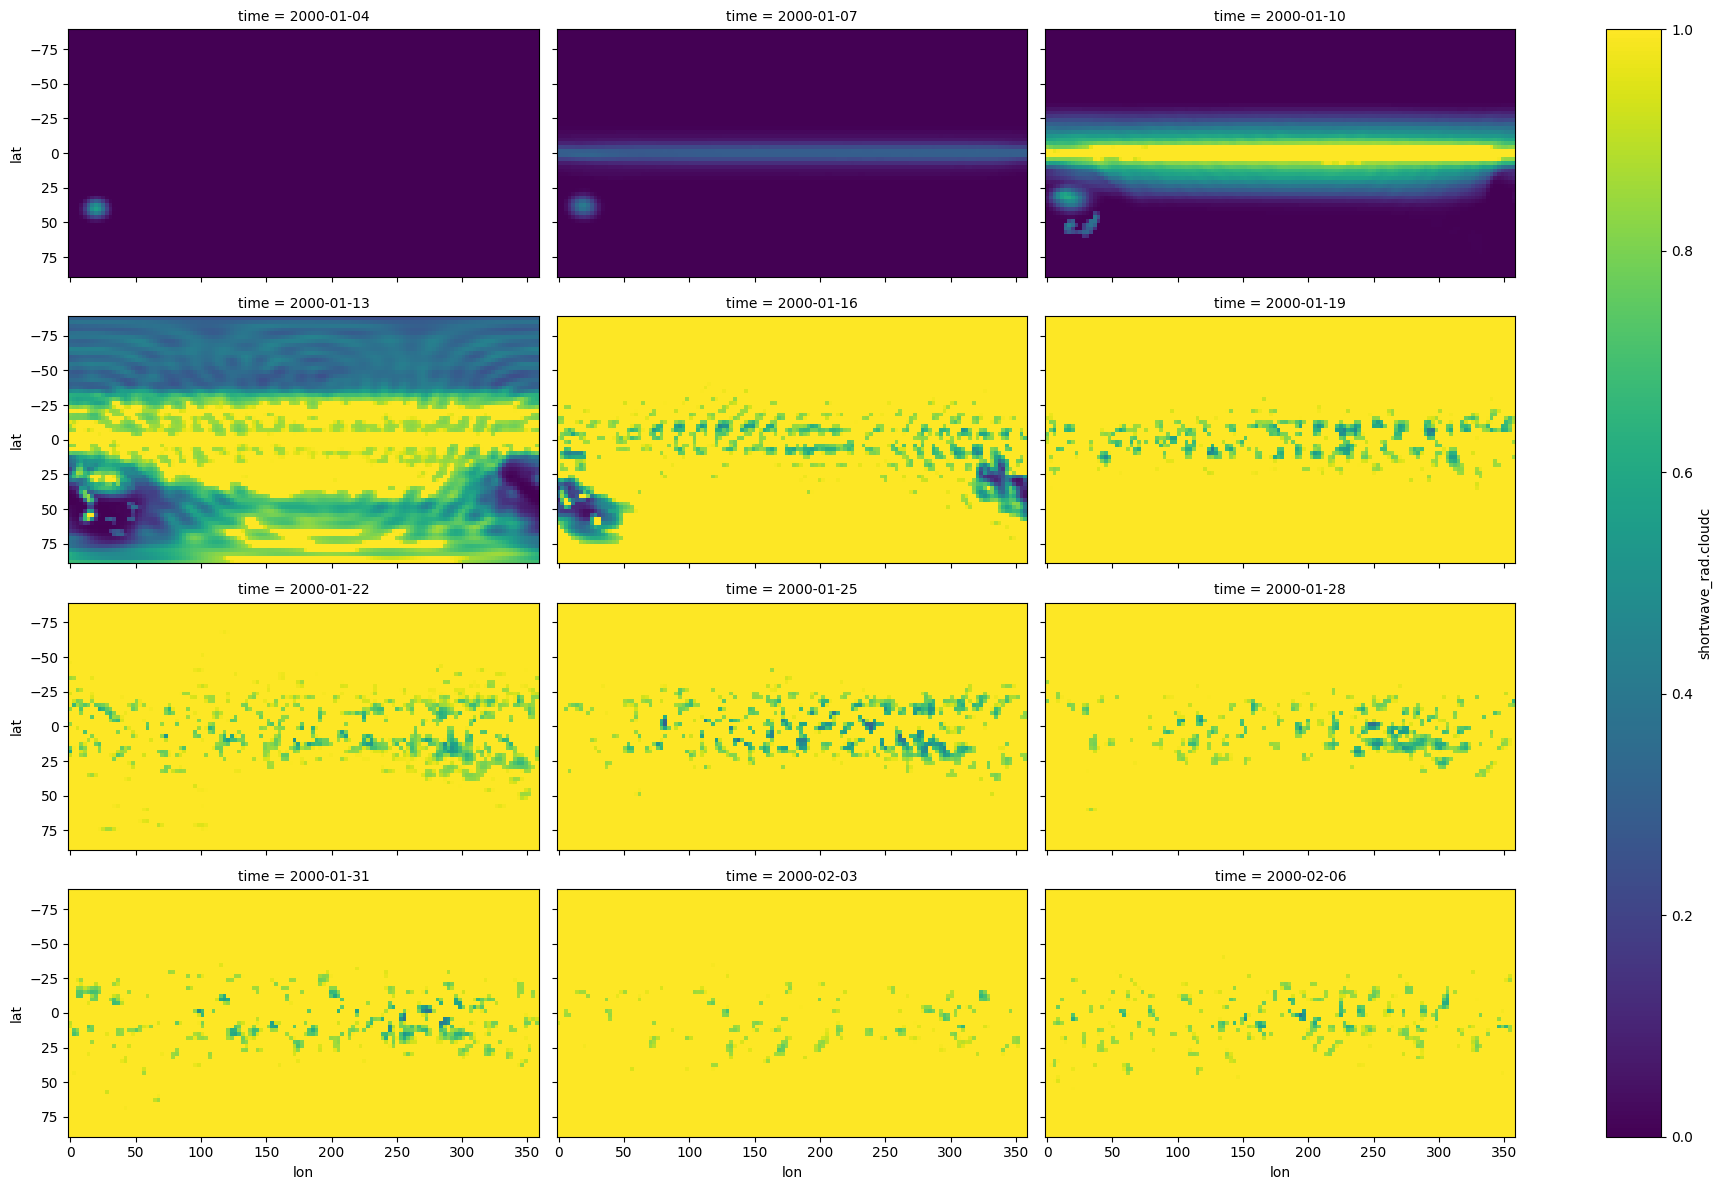

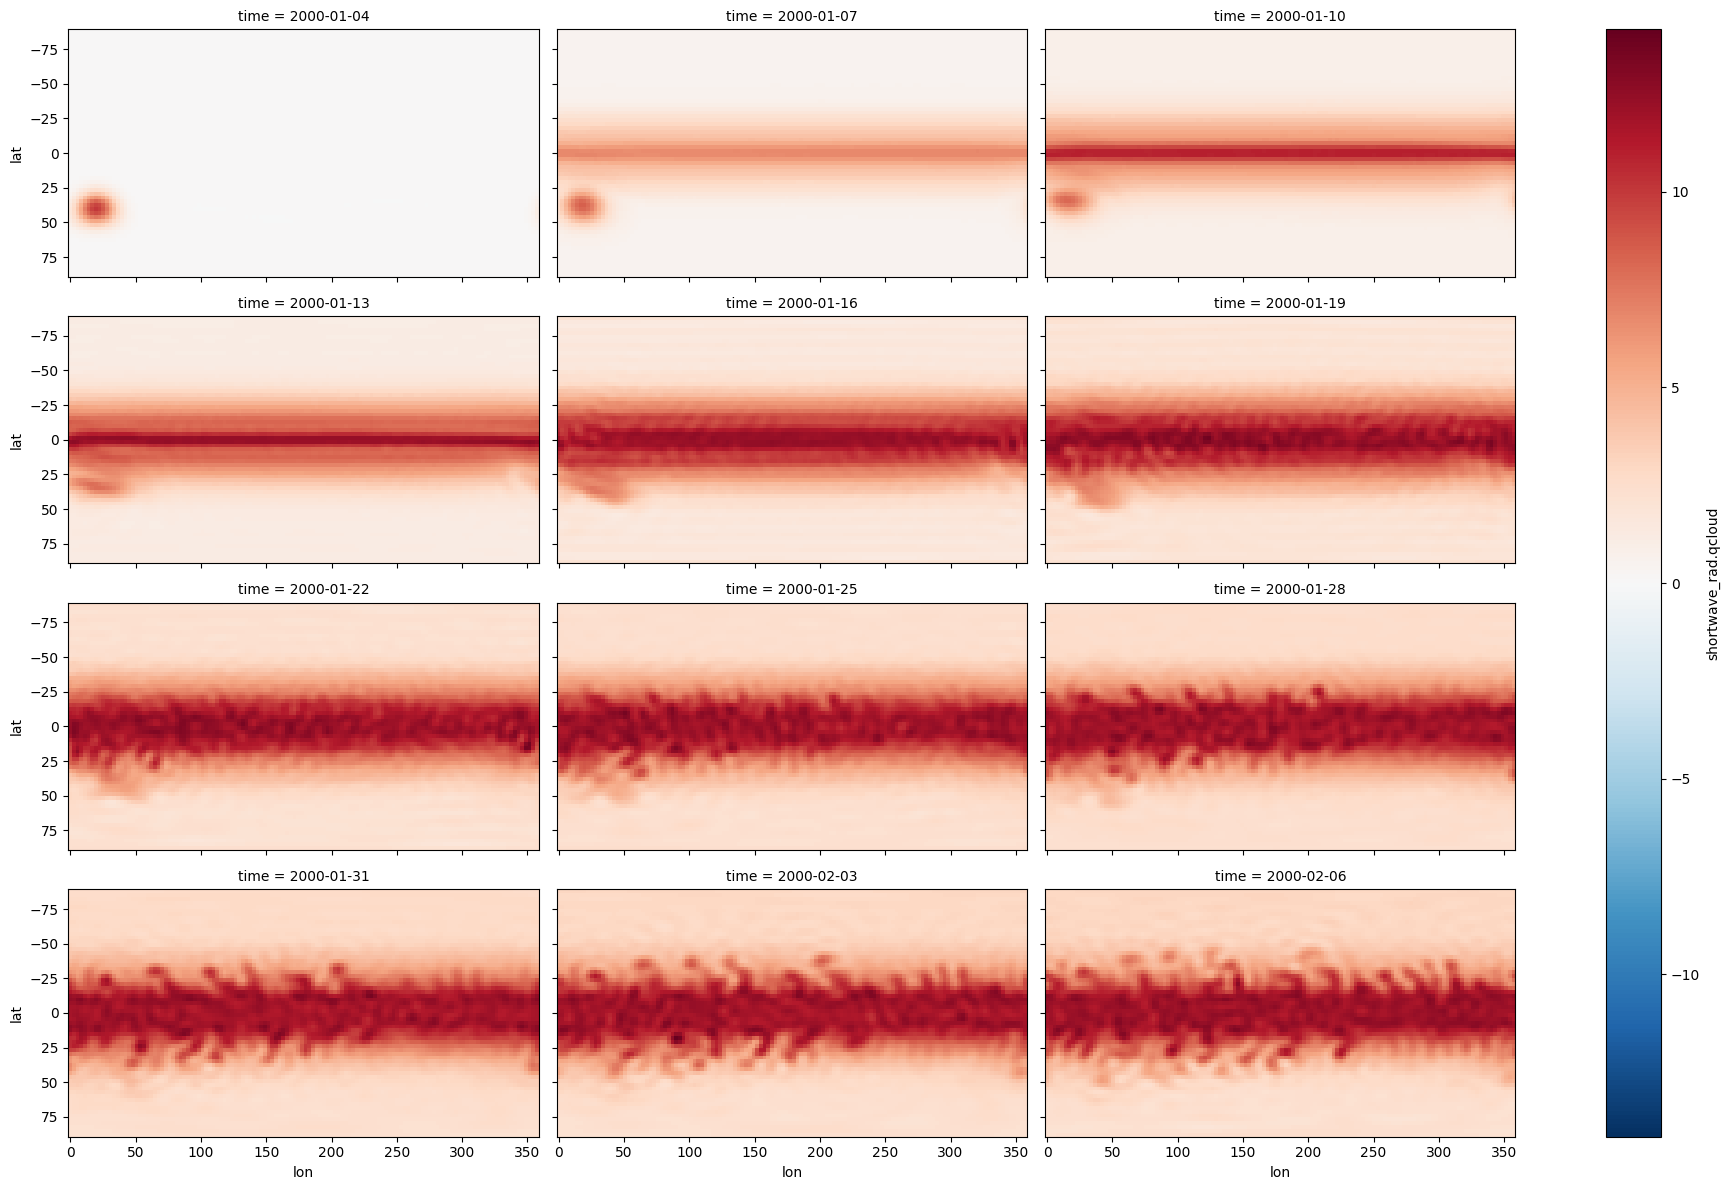

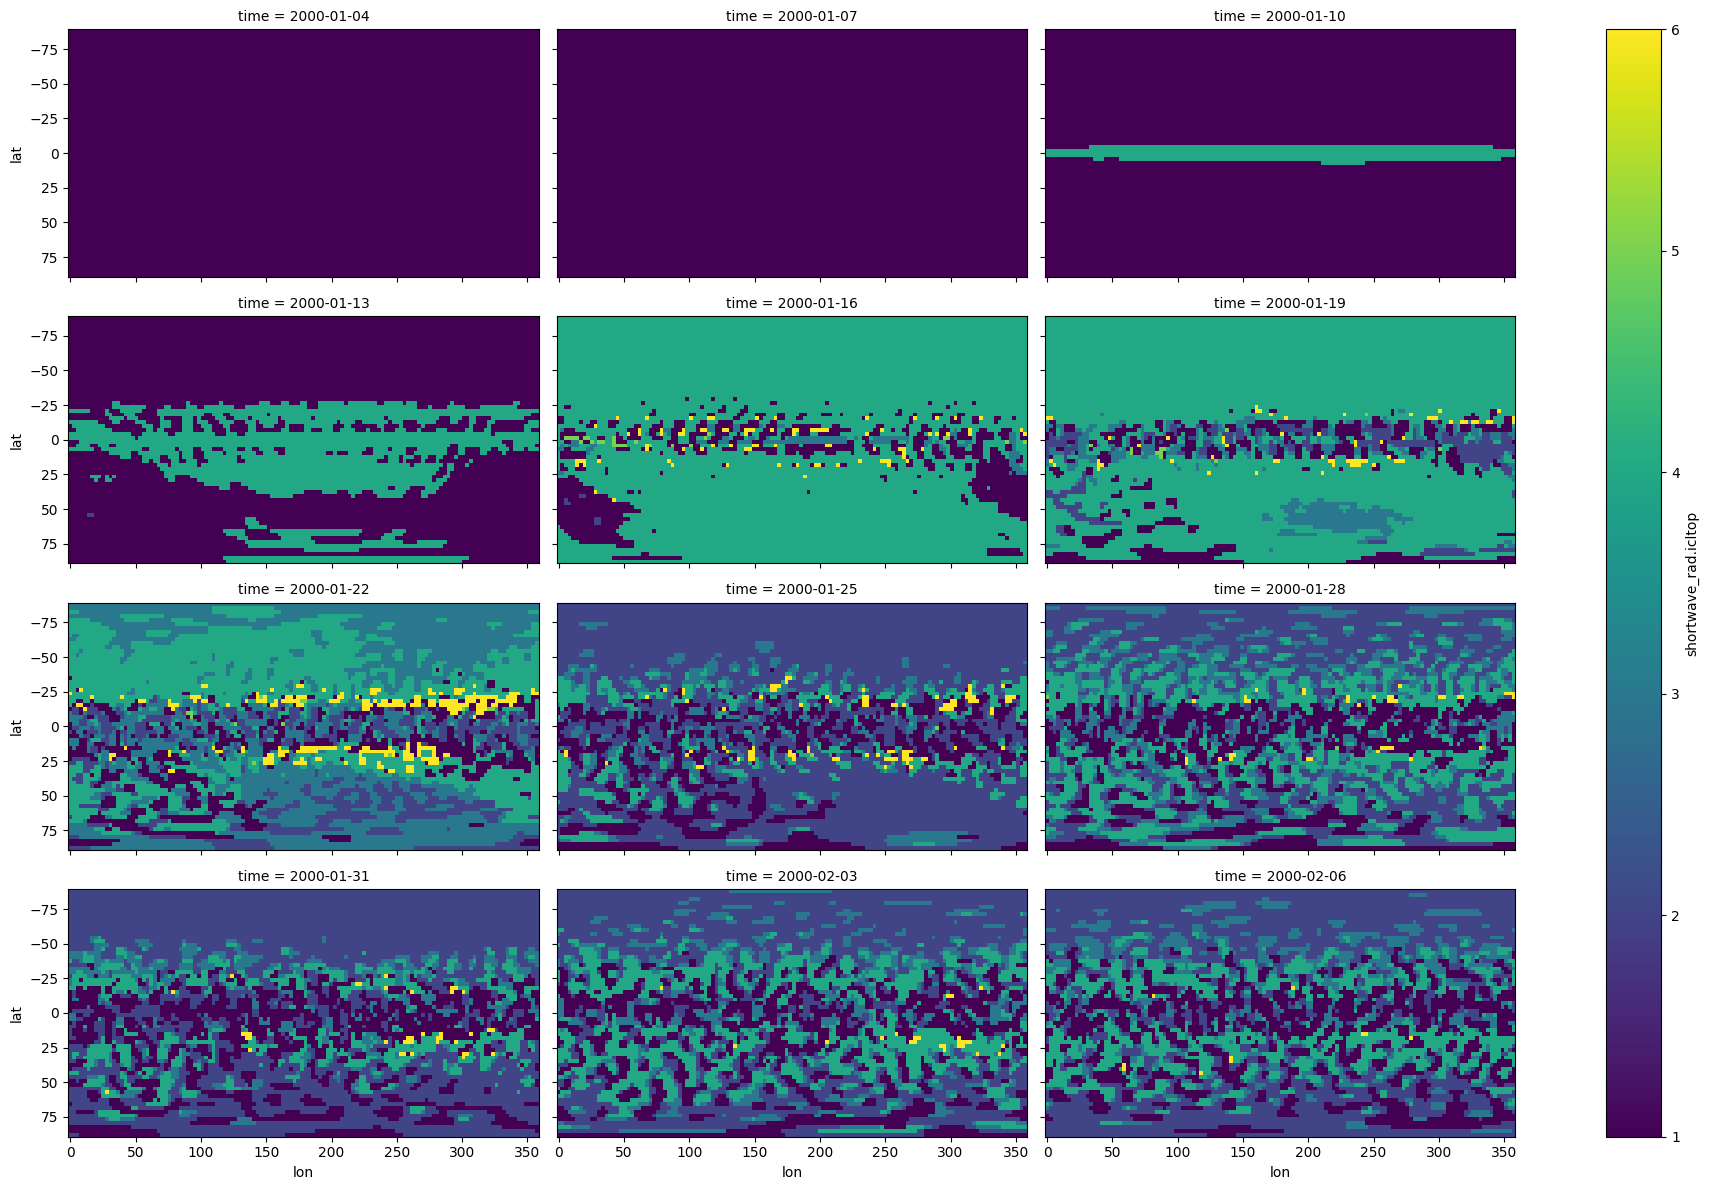

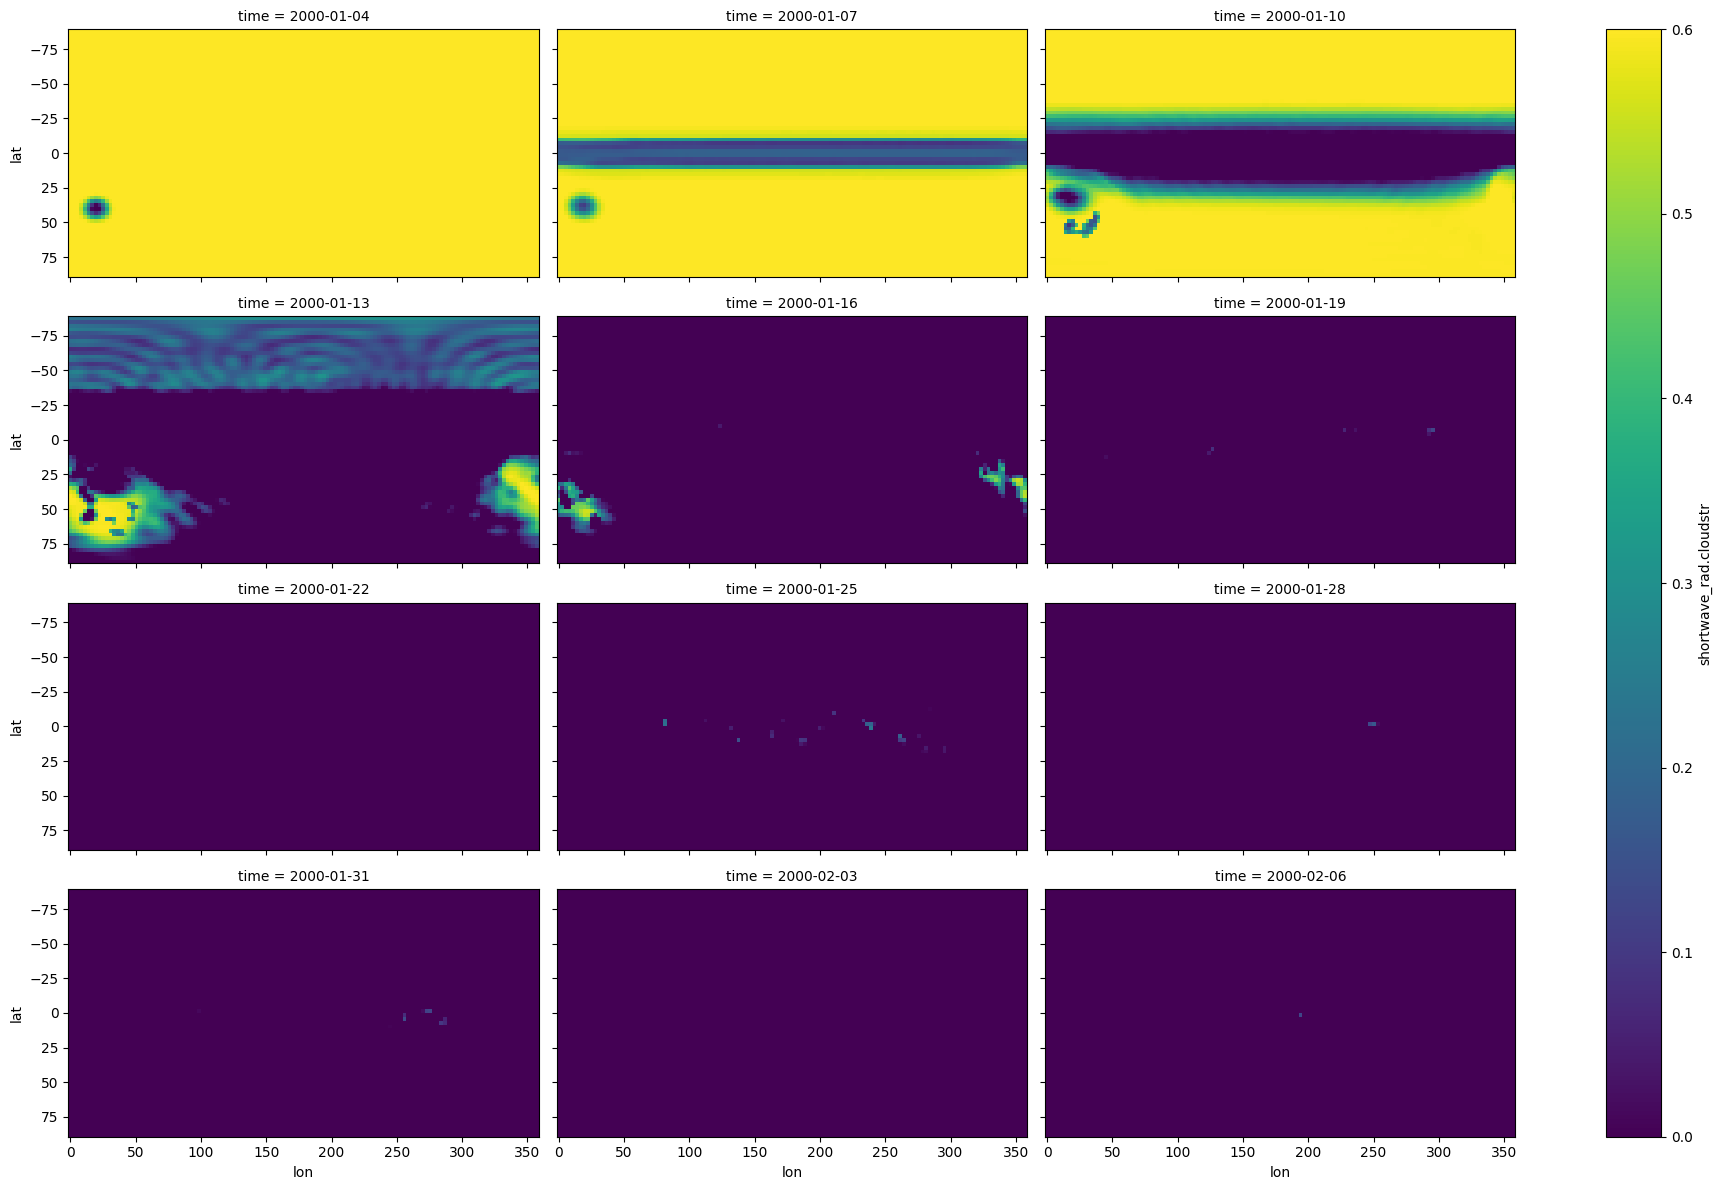

In [21]:
pred_ds['shortwave_rad.cloudc'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2, yincrease=False);
pred_ds['shortwave_rad.qcloud'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2, yincrease=False);
pred_ds['shortwave_rad.icltop'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2, yincrease=False);
pred_ds['shortwave_rad.cloudstr'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2, yincrease=False);